**DEEP NEURAL NETWORK FOR TAMIL DIGITS RECOGNITION**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**IMPORTS AND LIBRARIES**

In [0]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import glob
import librosa
import datetime as dt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix

**DATA PRE-PROCESSING**

In [0]:
os.chdir("/content/gdrive/My Drive/SRU Project/Tamil Digits")
lis = os.listdir()
lis


d = {'One' : 1,'Two' : 2,'Three' : 3, 'Four' : 4, 'Five' : 5, 'Six' : 6, 'Seven' : 7, 'Eight' : 8, 'Nine' : 9, 'Zero': 0}
data2 = []
for i in (range(len(lis) - 1)):
  print(lis[i])
  k = len(lis[i])
  for file in glob.glob(lis[i] + "/" + "*.wav"):
    y, sr = librosa.load(file)
    mfccs = librosa.feature.mfcc(y = y)
    data2.append([mfccs , d[lis[i]]])

np.random.shuffle(data2)
#print(data2)

shp = []
for i in range(len(data2)):
  shp.append(data2[i][0].shape[1])

#print(max(shp))
z = max(shp)

np.save("mfcc_tamil" , data2)

In [0]:
data2 = np.load('/content/gdrive/My Drive/SRU Project/Tamil Digits/mfcc_tamil.npy' , allow_pickle= True)

x = []
y = []
for i in range(len(data2)):
  val = data2[i][0].shape[1]
  if(val != z):
    zero = np.zeros((20 , z - val))
    new_data = np.append(data2[i][0] , zero , axis = 1)
    x.append(new_data)
  else:
    x.append(data2[i][0])
  y.append(data2[i][1])

x = np.array(x)
y = np.array(y)

train_x = x[:220]
train_y = y[:220]
test_x = x[210:]
test_y = y[210:]

print("Training Data Dimensions = " + str(train_x.shape))
print("Training Labels Dimensions = " + str(train_y.shape))
print("Test Data Dimensions = " + str(test_x.shape))
print("Test Labels Dimensions = " + str(test_y.shape))

**LSTM MODEL**

In [30]:
class LSTM(nn.Module):


  def __init__(self , inp, hidden, batch, out, layers):

    super(LSTM, self).__init__()


    self.inp = inp
    self.hidden = hidden
    self.batch = batch
    self.out = out
    self.layers = layers


    self.rnn = nn.LSTM(self.inp, self.hidden, self.layers, dropout = 0.1)
    self.fc = nn.Sequential(nn.Linear(self.hidden, self.out))


  
  def forward(self, x):

    output , hide = self.rnn(x)
    lstm_out = self.fc(output[-1])
    prediction = F.softmax(lstm_out, dim = 1)

    return prediction

train_y_ohe = []
for i  in range(len(train_y)):
  k = np.eye(10)[int(train_y[i])]
  train_y_ohe.append(k)

test_y_ohe = []
for i  in range(len(test_y)):
  k = np.eye(10)[int(test_y[i])]
  test_y_ohe.append(k)

train_y_ohe = np.array(train_y_ohe)
test_y_ohe = np.array(test_y_ohe)
print(test_y_ohe.shape)
print(train_y_ohe.shape)

batch = 20
epochs = 100
loss = []


lstm = LSTM(inp = 81, hidden = 10, batch = batch, out = 10, layers=2)
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)

for ep in range(epochs):


  for i in range(0, len(train_x), batch):


    batch_x = torch.Tensor(train_x[i : i + batch]).permute(1,0,2)
    #batch_y = torch.Tensor(train_y[i : i + batch]).type(torch.LongTensor)
    batch_y = torch.Tensor(train_y_ohe[i : i + batch])#.type(torch.LongTensor)


    lstm.zero_grad()
    pred = lstm(batch_x)
    los = loss_function(pred , batch_y)
    los.backward()
    optimizer.step()


  print('EPOCH = ' + str(ep))
  print(los)
  loss.append(los)


correct = 0
total = 0
predict = []
real = []


with torch.no_grad():


  #real_class = torch.Tensor(test_y).type(torch.LongTensor)
  real_class = torch.Tensor(train_y_ohe)#.type(torch.LongTensor)
  scores = lstm(torch.Tensor(train_x).permute(1,0,2))

print(real_class)
print(scores)


array = []
for i in range(len(scores)):
  k = scores[i]
  m = torch.max(k)
  for j in range(len(k)):
    if(k[j] == m):
      array.append(j)
      break

for i in range(len(scores)):
  if(array[i] == int(train_y[i])):
    correct = correct + 1

print("Accuracy = " + str(correct*100/len(scores)))

Training Data Dimensions = (220, 20, 81)
Training Labels Dimensions = (220,)
Test Data Dimensions = (20, 20, 81)
Test Labels Dimensions = (20,)
(20, 10)
(220, 10)
EPOCH = 0
tensor(0.0896, grad_fn=<MseLossBackward>)
EPOCH = 1
tensor(0.0886, grad_fn=<MseLossBackward>)
EPOCH = 2
tensor(0.0876, grad_fn=<MseLossBackward>)
EPOCH = 3
tensor(0.0847, grad_fn=<MseLossBackward>)
EPOCH = 4
tensor(0.0815, grad_fn=<MseLossBackward>)
EPOCH = 5
tensor(0.0765, grad_fn=<MseLossBackward>)
EPOCH = 6
tensor(0.0689, grad_fn=<MseLossBackward>)
EPOCH = 7
tensor(0.0736, grad_fn=<MseLossBackward>)
EPOCH = 8
tensor(0.0664, grad_fn=<MseLossBackward>)
EPOCH = 9
tensor(0.0630, grad_fn=<MseLossBackward>)
EPOCH = 10
tensor(0.0594, grad_fn=<MseLossBackward>)
EPOCH = 11
tensor(0.0566, grad_fn=<MseLossBackward>)
EPOCH = 12
tensor(0.0627, grad_fn=<MseLossBackward>)
EPOCH = 13
tensor(0.0516, grad_fn=<MseLossBackward>)
EPOCH = 14
tensor(0.0507, grad_fn=<MseLossBackward>)
EPOCH = 15
tensor(0.0601, grad_fn=<MseLossBackward>)

**TRAINING RESULTS**

Total number of test samples = 220
 
Correct predictions = 192
 
Accuracy = 87.27272727272727%
 
[[13  0  1  0  1  1  0  2  1  1]
 [ 0 17  1  1  1  1  0  1  1  0]
 [ 0  0 20  0  0  0  0  0  1  0]
 [ 0  0  0 22  0  0  0  1  0  0]
 [ 0  0  0  0 20  1  0  0  1  1]
 [ 0  0  0  0  1 20  0  0  0  1]
 [ 0  0  0  1  0  1 19  1  0  0]
 [ 0  0  0  0  0  0  0 22  0  0]
 [ 0  1  1  0  2  0  0  0 19  0]
 [ 0  0  0  0  1  0  0  0  0 20]]
 


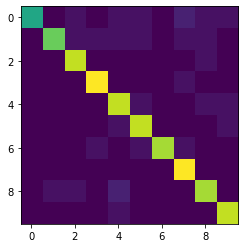

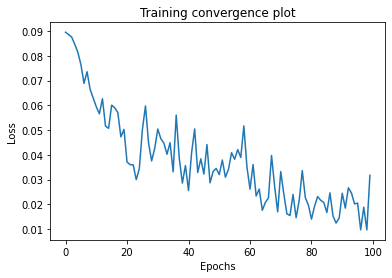

In [31]:
print("Total number of test samples = " + str(len(scores)))
print(" ")
print("Correct predictions = " + str(correct))
print(" ")
print("Accuracy = " + str(((correct/len(scores))*100)) + "%") 
print(" ")


cfm = confusion_matrix(train_y, array)
print(cfm)
print(" ")
plt.imshow(cfm)
plt.show()


for i in range(len(loss)):
  loss[i] = float(loss[i])


plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training convergence plot')
plt.show()

**MODEL ARCHITECTURE**

In [11]:
lstm

LSTM(
  (rnn): LSTM(81, 10, num_layers=2, dropout=0.1)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
  )
)

**TESTING RESULTS**

Total number of test samples = 20
 
Correct predictions = 13
 
Accuracy = 65.0%
 
[[1 0 0 0 1 1 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 2 0 1 0]
 [0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 2]]
 


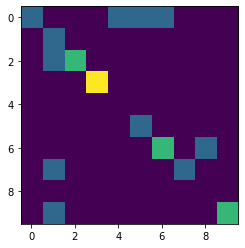

In [51]:
correct = 0
total = 0
predict = []
real = []


with torch.no_grad():


  #real_class = torch.Tensor(test_y).type(torch.LongTensor)
  real_class = torch.Tensor(test_y_ohe)#.type(torch.LongTensor)
  scores = lstm(torch.Tensor(test_x).permute(1,0,2))



array = []
for i in range(len(scores)):
  k = scores[i]
  m = torch.max(k)
  for j in range(len(k)):
    if(k[j] == m):
      array.append(j)
      break

for i in range(len(scores)):
  if(array[i] == int(test_y[i])):
    correct = correct + 1

print("Total number of test samples = " + str(len(scores)))
print(" ")
print("Correct predictions = " + str(correct))
print(" ")
print("Accuracy = " + str((correct)/len(scores)*100) + "%") 
print(" ")


cfm = confusion_matrix(test_y, array)
print(cfm)
print(" ")
plt.imshow(cfm)
plt.show()


**SAVING MODEL WEIGHTS**

In [60]:
torch.save(lstm , "model_weights.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
